# House Prices With Advanced Feature Engineering


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats
# from scipy.stats.mstats import winsorize

# Overview

In [2]:
# Data set documentation
house_data_description = open('./data/data_description.txt')
text = house_data_description.read()
print(text)

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [3]:
#a brief look at the dataset
houses_train = pd.read_csv('./data/train.csv')
houses_test = pd.read_csv('./data/test.csv')

original_numerical_features = houses_test.select_dtypes(include=np.number).columns.to_list()
original_categorical_features = houses_test.select_dtypes(exclude=np.number).columns.to_list()


print(f"shape of test: {houses_train.shape}")
print(f"shape of test: {houses_test.shape}")
houses_train.head()

shape of test: (1460, 81)
shape of test: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
#splitting features to categorical and numerical
categorical = houses_train.dtypes[(houses_train.dtypes==object)].index
numerical = houses_train.dtypes[(houses_train.dtypes!=object)].index[1:-1] #omitting id and SalePrice (first and last dtypes respectively)

print(f"Numerical features: {numerical.size}")
print(f"Categorical features: {categorical.size}")

Numerical features: 36
Categorical features: 43


# SalePrice statistic

First, we would like to understand the distribution describing the target variable. We aim to work with normaly distributed variables (target and features) because then, methods that are non-invariant to standartization such as LASSO or ridge regression should work more properly.
Also, for sake of interpertability, validity of measures of association (such as correlations), and insensitivity to the features scales, the different variables should be normalized.  

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64
Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


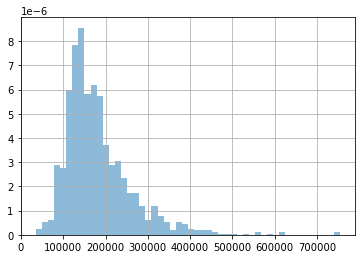

In [5]:
print(houses_train['SalePrice'].describe())
print(f"Skewness: {houses_train['SalePrice'].skew()}")
print(f"Kurtosis: {houses_train['SalePrice'].kurt()}")
houses_train['SalePrice'].hist(bins=50, density=True, alpha=0.5);

Lets try the normal and log-normal for the target:

C:\Users\shosh\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\shosh\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness_norm: 0.040816164129252305
Kurtosis_norm: -0.12382914300221293
Skewness_Log norm: 0.1212103673013655
Kurtosis_Log norm: 0.8026555069117713


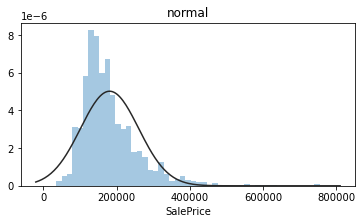

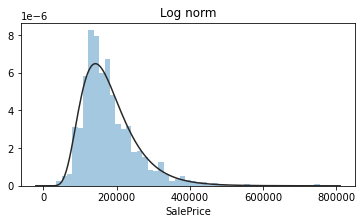

In [6]:
mu = np.mean(houses_train['SalePrice'])
sigma = np.std(houses_train['SalePrice'])
norm = np.random.normal(mu, sigma, houses_train['SalePrice'].shape)

plt.figure(figsize=(6, 3))
sns.distplot(houses_train['SalePrice'],kde=False,fit=scipy.stats.norm)
plt.title("normal")
print("Skewness_norm:", scipy.stats.skew(norm))
print("Kurtosis_norm:", scipy.stats.kurtosis(norm))


log_sp = np.log(houses_train['SalePrice'])
plt.figure(figsize=(6, 3),)
sns.distplot(houses_train['SalePrice'], kde=False, fit=scipy.stats.lognorm)
plt.title("Log norm")
print("Skewness_Log norm:", scipy.stats.skew(log_sp))
print("Kurtosis_Log norm:", scipy.stats.kurtosis(log_sp))

In [7]:
houses_train["SalePrice_log"] = log_sp

Seems more like a log normal distribution


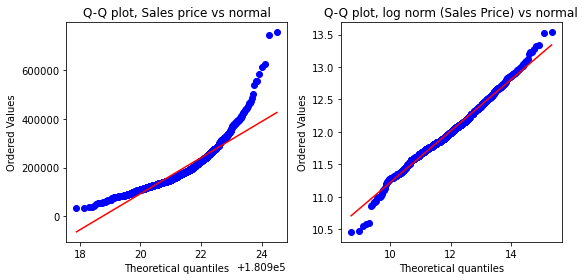

In [8]:
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
scipy.stats.probplot(houses_train['SalePrice'], dist=scipy.stats.norm, sparams=(houses_train['SalePrice'].mean()), plot=plt)
plt.title('Q-Q plot, Sales price vs normal')
plt.subplot(1,2,2)
scipy.stats.probplot(log_sp, dist=scipy.stats.norm, sparams=(log_sp.mean()), plot=plt,)
plt.title('Q-Q plot, log norm (Sales Price) vs normal');
plt.tight_layout()

# Features

##### outliers
A common method to define outliers is the “3 times the standard deviation” rule. For now, we will use this method and replace all the exceptional values with lower_limit/upper_limits defined by 3std with respect to the feature mean.
We also apply the same approuch on the test using the mean and std calculated from the train.

In [9]:

for col in list(numerical):
    mean_col = houses_train[col].mean()
    std_col = houses_train[col].std()
    lower_limit = mean_col - 3*std_col
    upper_limit = mean_col + 3*std_col
    houses_train[col] = pd.Series([min(max(a,lower_limit),upper_limit) for a in houses_train[col]])
    houses_test[col] = pd.Series([min(max(a,lower_limit),upper_limit) for a in houses_test[col]])


Now lets move on to examine the features. First. how many NAs do we have?

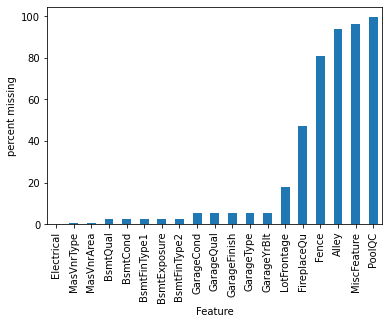

In [10]:
#for train
missing_train = houses_train.isnull().sum()*100/len(houses_train)
missing_train = missing_train[missing_train > 0]
missing_train.sort_values(inplace=True)
missing_train.plot.bar()
plt.xlabel("Feature")
plt.ylabel("percent missing")
plt.show();
#for test
missing_test = houses_test.isnull().sum()*100/len(houses_train)
missing_test = missing_test[missing_test > 0]
missing_test.sort_values(inplace=True)

In [11]:
missing = set(missing_train.index).union(set(missing_test.index))

Some features have large portions of NAs, But these are not actually missing values as they reprecent the absence of a house characraristic such as not having a pool (PoolQC, Alley etc.). However the MiscFeature which describe the present of some special charactaristics (such as 2nd garage, elevator etc.) could be discarded entirely as those few special features are not comparable...  


For numerical data we can later fill in the missing values with columns averages. For categorical, we can change to `None`

We should note that, when filling in the missing values with averages, we are not affecting the average, but are affecting the general distribution, and that should be taken into consideration.

In [12]:
# columns where NaN values have meaning e.g. no pool etc.
cols_fill_with_none = [col for col in missing if col in categorical]
cols_fill_with_average = [col for col in missing if col in numerical]
# replace 'NaN' with 'None' in these columns
for col in cols_fill_with_none:
    houses_train[col].fillna("None",inplace=True)
    houses_test[col].fillna("None",inplace=True)
    
for col in cols_fill_with_average:
    houses_train[col].fillna(houses_train[col].mean(),inplace=True)
    houses_test[col].fillna(houses_test[col].mean(),inplace=True)

# Correlations

First, we will examine the correlation between the independent variables and the dependent variable (our target) and among themselves. we will test quantitative features first.

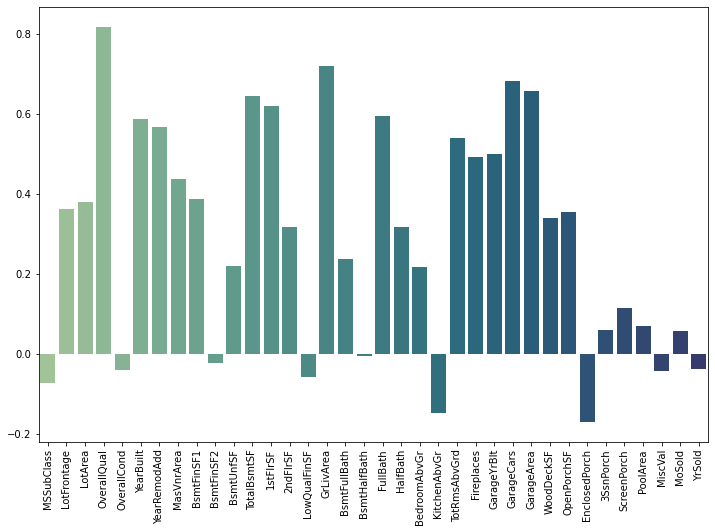

In [13]:
cols = list(numerical) + ["SalePrice_log"]

corrs = houses_train[cols].corr()["SalePrice_log"]
fig, ax = plt.subplots(figsize=(12, 8))
g = sns.barplot(
    x=corrs[:-1].index,
    y=corrs[:-1].values, palette="crest")
plt.xticks(rotation=90)
plt.show();

Looking at the correlations between SalePrice and numerical features, we can see that setting a threshold of absolute value of $|R|=0.4$ will maintain about half of the features. 

<ipython-input-14-d08145719c69>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(correlations, dtype=np.bool)


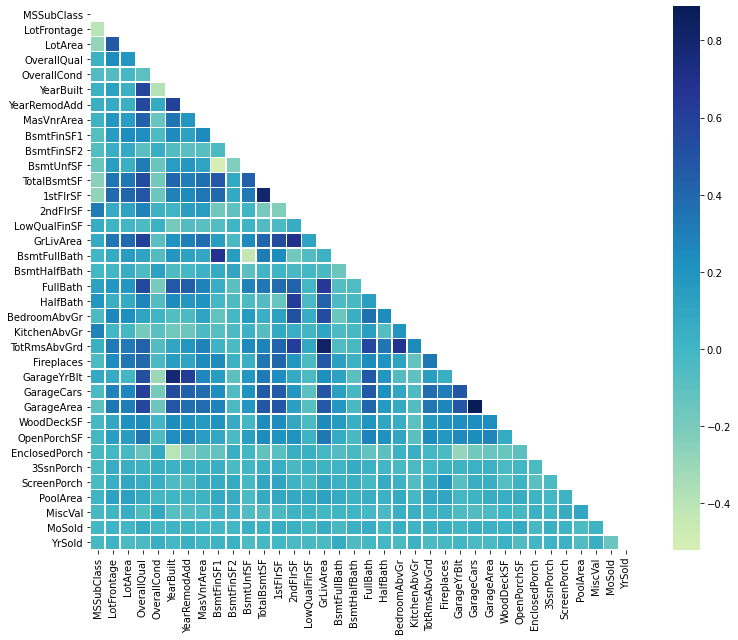

In [14]:
correlations = houses_train[numerical].corr()
mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(correlations, mask=mask, center=0,
            square=True, linewidths=.5,cmap="YlGnBu")        
plt.show()

We can see that some features are highly correlated. We shall consider remove some of features in training to avoid multicolinearity

As mentioned above, we shall also try to work with normaly distributed features

In [15]:
normal_data = pd.concat([pd.Series(houses_train[numerical].kurt(),name="Kurtosis"),pd.Series(houses_train[numerical].skew(),name="Skewness")],axis=1)
normal_data

,Kurtosis,Skewness
MSSubClass,1.406664,1.368878
LotFrontage,2.080783,0.531372
LotArea,12.514219,2.716906
OverallQual,-0.009919,0.248222
OverallCond,0.876145,0.728585
YearBuilt,-0.472936,-0.605624
YearRemodAdd,-1.272245,-0.503562
MasVnrArea,2.635188,1.791767
BsmtFinSF1,-0.231755,0.746550
BsmtFinSF2,9.291040,3.245254


By examining the kurtosis and skewness, we can find variables which their original distribution is far from normal. We would hope to normalize those. Lets try the lognormal (and specificaly focus on variables that are right now far from being normal such as LotArea, 3SsnPorch, PoolArea etc.).

In [16]:
log_house_train = np.log(houses_train[numerical]+0.001)
log_normal_data = pd.concat([pd.Series(log_house_train[numerical].kurt(),name="Kurtosis"),pd.Series(log_house_train[numerical].skew(),name="Skewness")],axis=1)
log_normal_data

,Kurtosis,Skewness
MSSubClass,-1.135062,0.224620
LotFrontage,3.094271,-1.155287
LotArea,2.603086,-0.719916
OverallQual,1.219737,-0.561527
OverallCond,2.179081,-0.204166
YearBuilt,-0.414741,-0.632693
YearRemodAdd,-1.263360,-0.511009
MasVnrArea,-1.823070,0.388752
BsmtFinSF1,-1.417959,-0.731690
BsmtFinSF2,3.999700,2.441936


Now Lets find that features for which taking log indeed improve

In [17]:
diff = abs(normal_data)-abs(log_normal_data)
diff[(diff.Kurtosis>1) & (diff.Skewness>0)]

,Kurtosis,Skewness
LotArea,9.911133,1.996990
BsmtFinSF2,5.291340,0.803318
LowQualFinSF,5.728015,0.334796
EnclosedPorch,2.861515,0.504004
3SsnPorch,2.189324,0.137534
ScreenPorch,1.540343,0.197349
MiscVal,36.354067,2.340390


Now lets keep the log of these features (and also keep in mind that some may not be relevant at all. e.g. MiscVal)

In [18]:
features_to_log = diff[(diff.Kurtosis>1) & (diff.Skewness>0)].index
for feature in features_to_log:
    houses_train[feature+"_log"]=np.log(houses_train[feature]+0.0001) # adding a small constant to avoid numerical instability
    houses_test[feature+"_log"]=np.log(houses_test[feature]+0.0001) # adding a small constant to avoid numerical instability

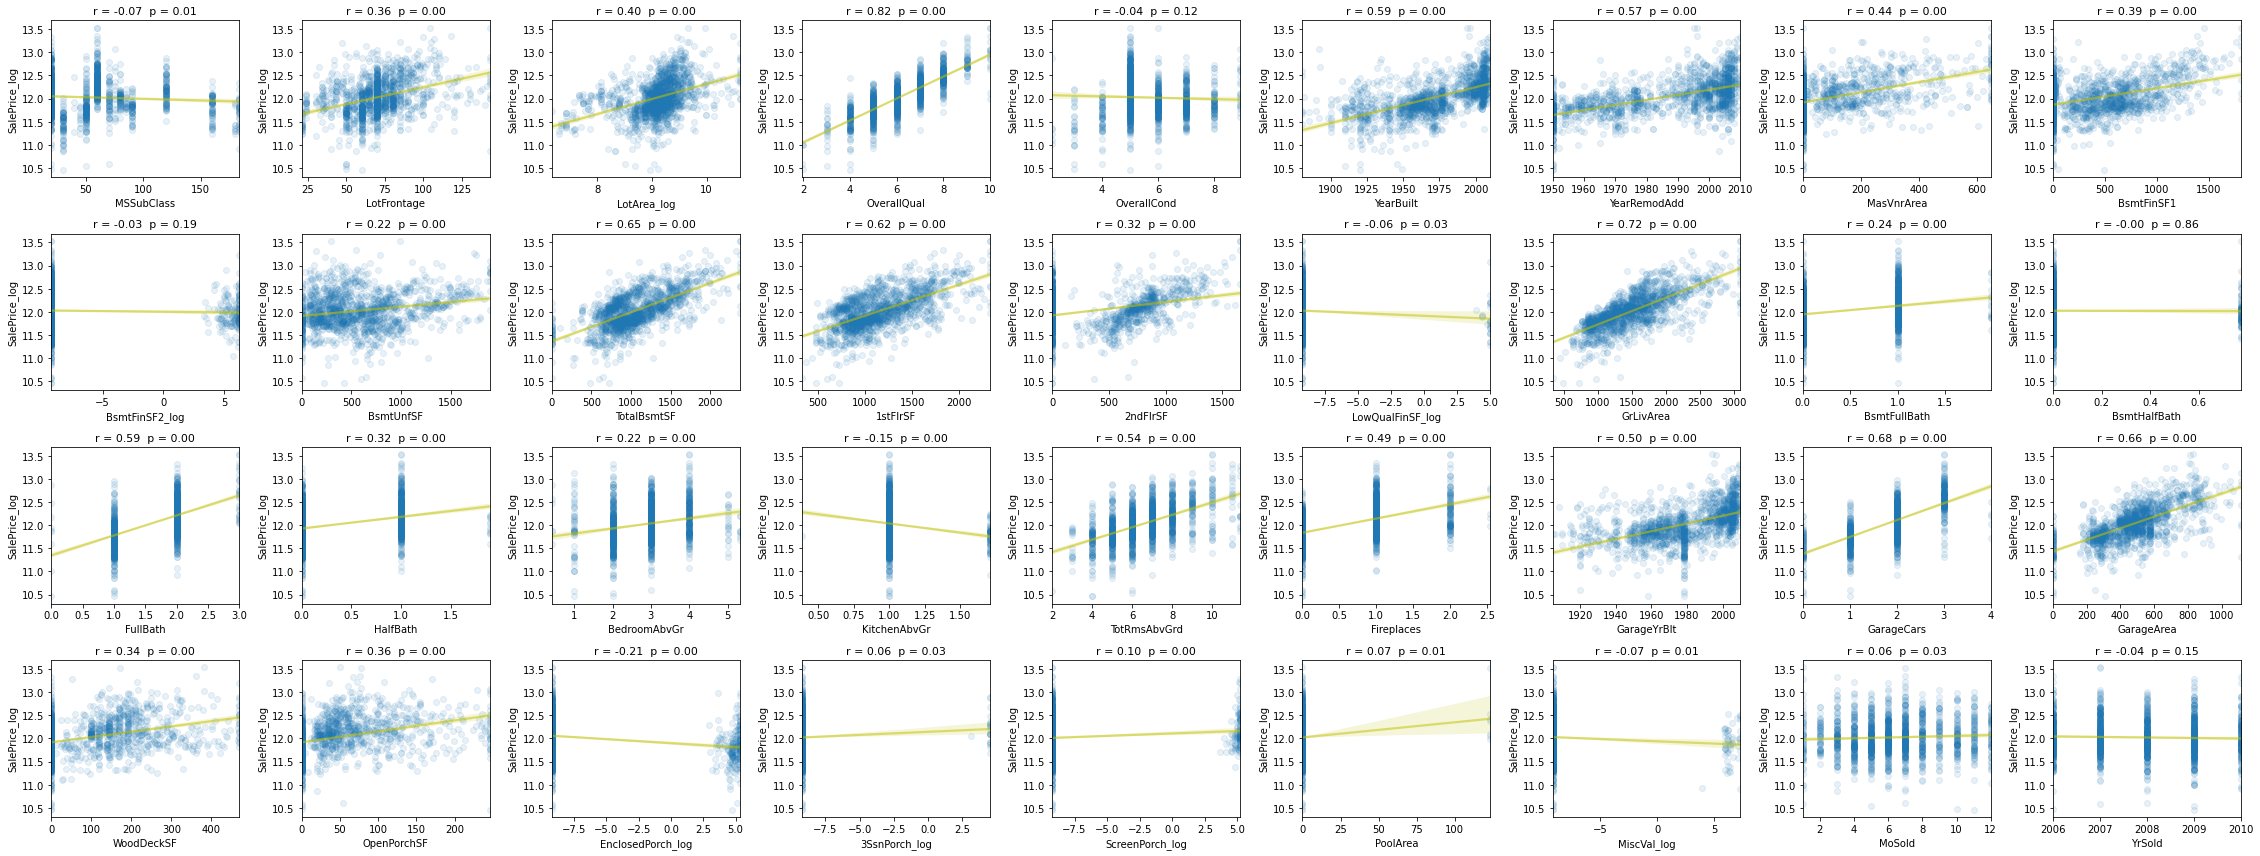

In [19]:
n_rows = 4
n_cols = 9

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*3.5,n_rows*3))
li_num_feats = list(numerical)

for r in range(0, n_rows):
    for c in range(0, n_cols):  
        i = r * n_cols + c
        if i < len(li_num_feats):
            
            feature_to_plot = li_num_feats[i]
            if feature_to_plot+"_log" in houses_train.columns:
                
                feature_to_plot = feature_to_plot+"_log"
            sns.regplot(x=houses_train[feature_to_plot], y=houses_train["SalePrice_log"], ax = axs[r][c],  scatter_kws={"alpha": 0.1}, line_kws={"color": "y", "alpha": 0.5}
)
            stp = scipy.stats.pearsonr(houses_train[feature_to_plot], houses_train["SalePrice_log"])
            
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "  " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show() 


These above plots help a lot when determining the dependancy of the target variable in the different quantitative features.
We can look at the estimated slopes of the different fits. fits with small slopes values correspond to features in which the target variable is somewhant independant (e.g. MoSold, YrSold etc.). However, some features are clearly correlated with the target variable and may contribute later on when we try to build our LR model (e.g OverallQual, TotRmsAbvGrd). 


Now Lets explore our categorical fearues..
We can boxplot the target variable for each group in each categorical feature

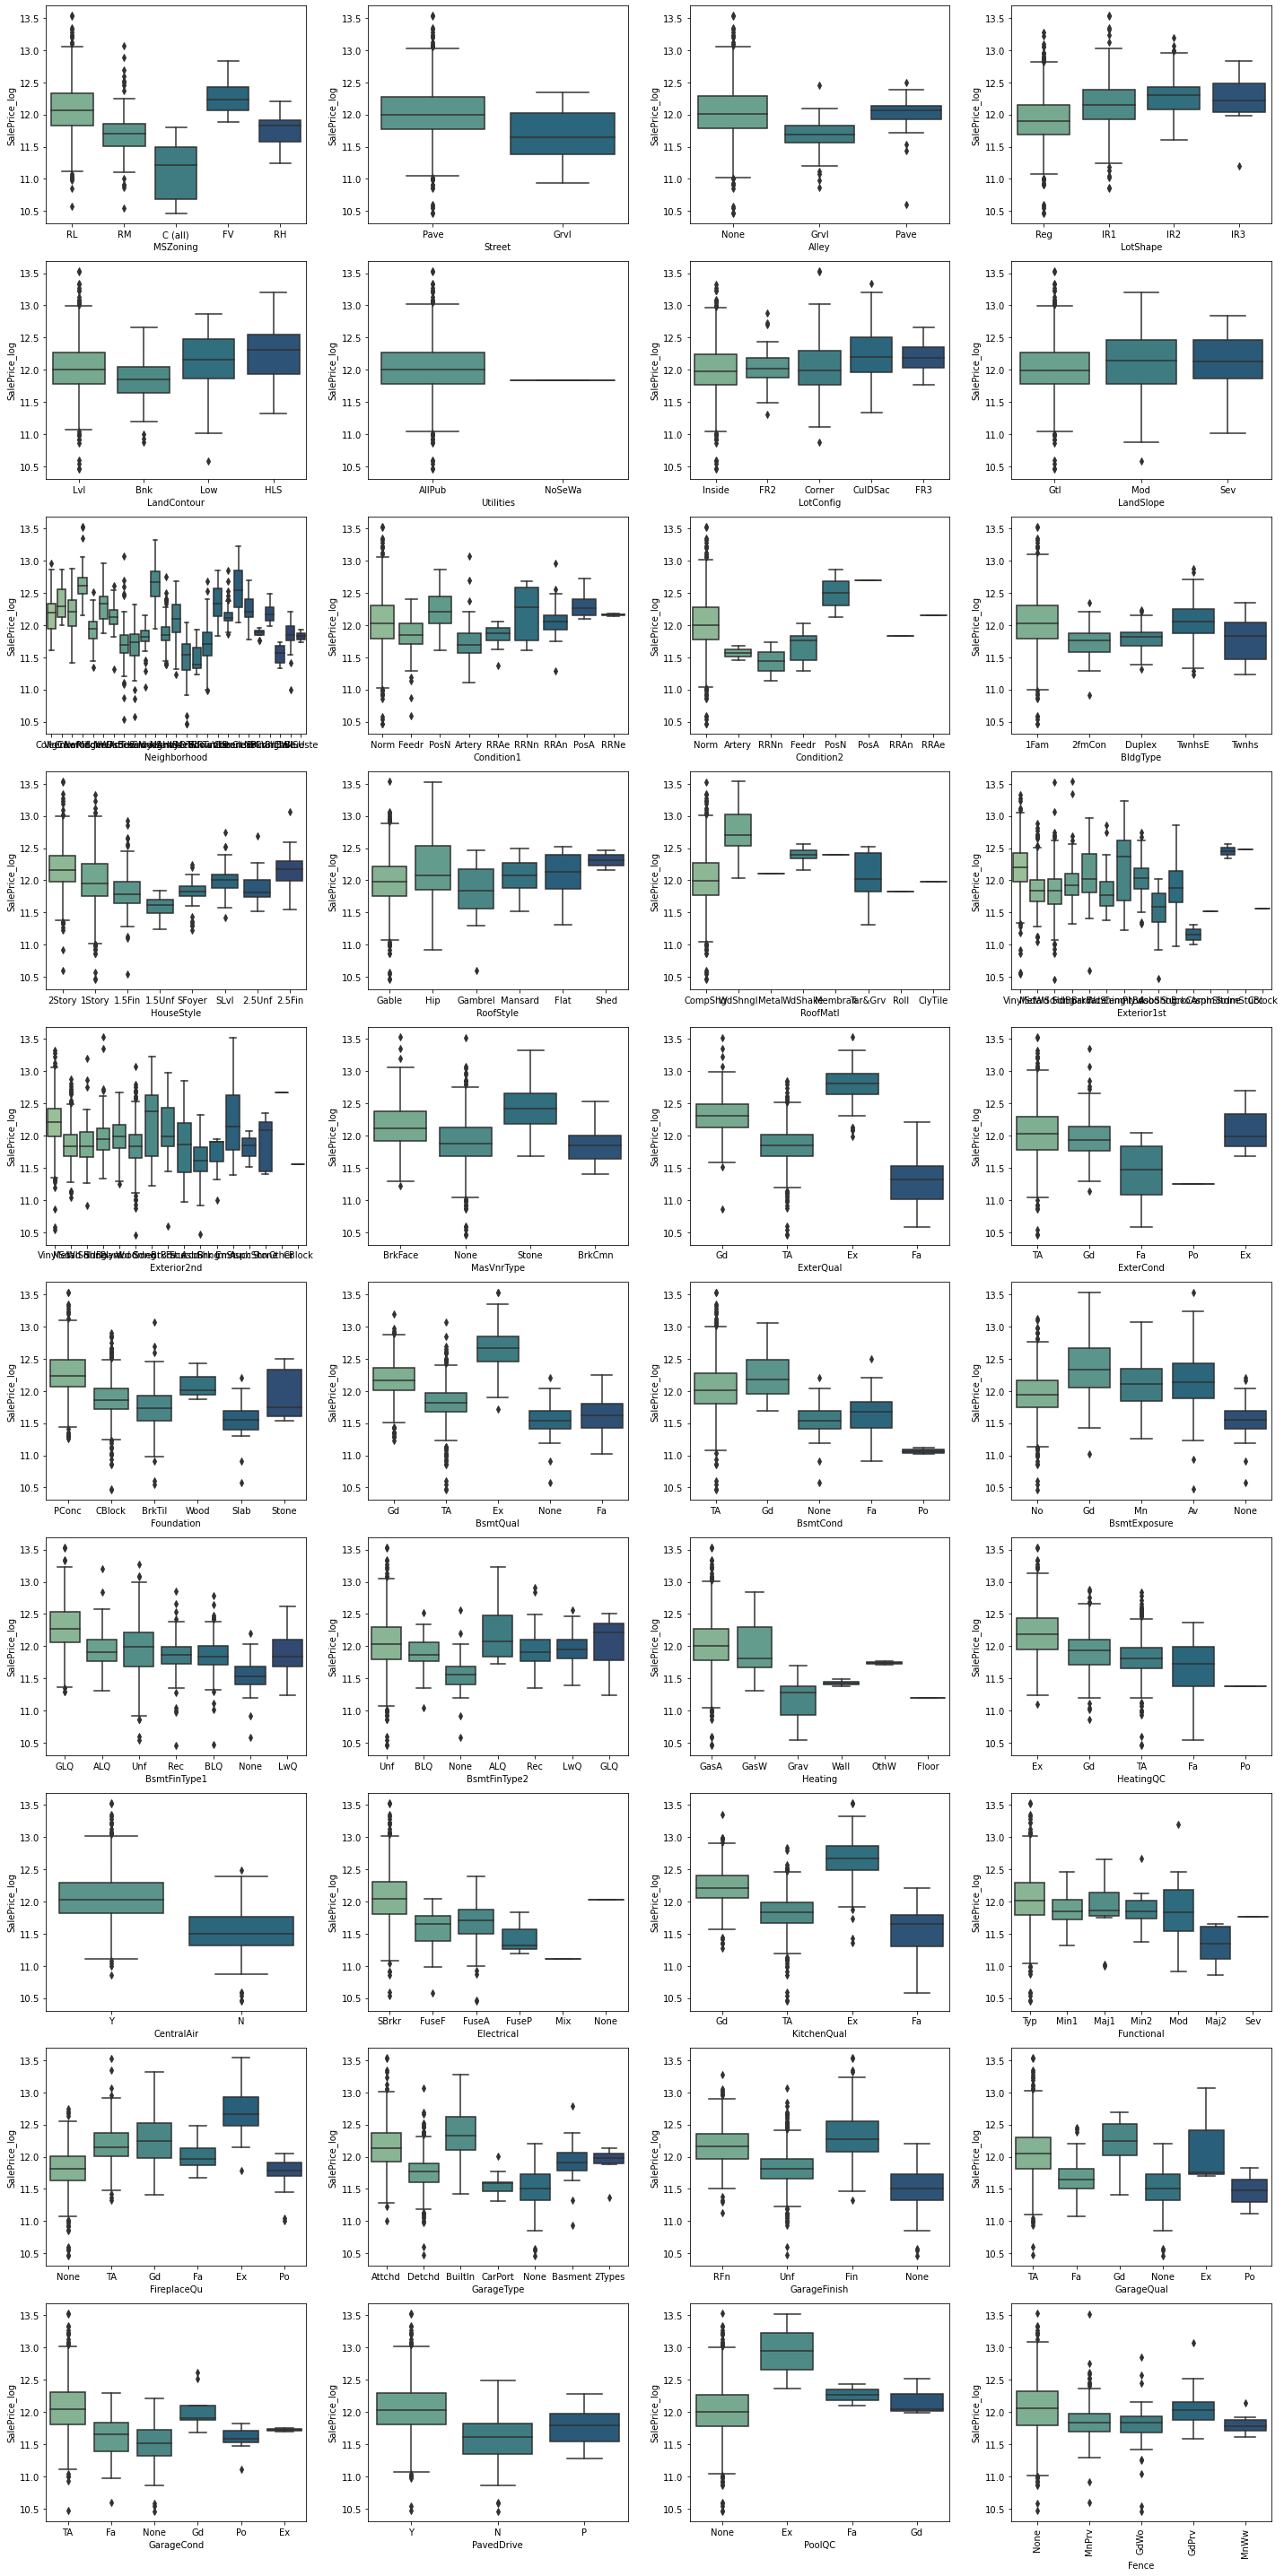

In [20]:
li_cat_feats = list(categorical)
nr_rows = 10
nr_cols = 4

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*5,nr_rows*4))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_cat_feats):
            sns.boxplot(data=houses_train, x=li_cat_feats[i], y="SalePrice_log", ax = axs[r][c], palette="crest")
            plt.xticks(rotation=90)
    
plt.tight_layout()    
plt.show()   

One can see that for some features the target variable distributions in different groups differ from each other quit a lot. Those will be good candidates for our model as the capture some of the variance in the target variable

Lets also print 2 box plots of critical numerical features

# Part 2

In [21]:
import sklearn
from sklearn import preprocessing
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [22]:
houses_train_modified = houses_train.copy()
houses_test_modified = houses_test.copy()

First, we want to factorize the categorical features so some basic techniques could handle them as numerical

In [23]:
for col in houses_train_modified[categorical]:
    grouped_target = houses_train_modified.groupby(col)["SalePrice"].mean().sort_values(ascending=True)
    factors = pd.factorize(grouped_target.index)[0]
    grouped_target = grouped_target.reset_index()
    grouped_target.drop("SalePrice",axis=1,inplace=True)
    grouped_target[col+"_fact"] = factors 
    houses_train_modified = pd.merge(left = houses_train_modified, right=grouped_target, on=col, how="left")
    houses_test_modified = pd.merge(left = houses_test_modified, right=grouped_target, on=col, how="left")
categorical_fact = categorical+'_fact'

In [24]:
numerical=houses_train_modified.select_dtypes(include=np.number).columns.to_list()
[numerical.remove(x) for x in ['Id','SalePrice_log', 'SalePrice']]

[None, None, None]

In [25]:
houses_test_modified[numerical]=houses_test_modified[numerical].fillna(-1) #handling categories abcsent from train
houses_train_modified = houses_train_modified[numerical] #without original categorical columns but with columns we created
houses_test_modified = houses_test_modified[numerical] #without original categorical columns but with columns we created

## Feature engineering

### K-means

We can try to cluster the datapoints and use the labels of the clusters as features. We may find it usefull later to also convert the arbitrary clusters' labels to factors corresponding to ranks oF the cluster mean SalePrice value as we did with existing categorical features. it is reasonable to combine different features that together could indicate the property total area to create a new feature that (intuitively) should be highly correlated with the target variable.

In [26]:
area_list = ["LotArea","TotalBsmtSF","1stFlrSF","2ndFlrSF","GrLivArea"]
area_features_df = houses_train_modified[area_list]

Before we do anything, we should determine the best possible k to cluster the data.
We can use elbow method to decide on that:

C:\Users\shosh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


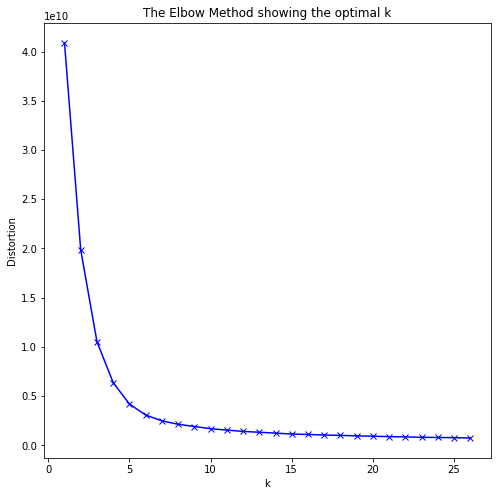

In [27]:
k_to_exmine = np.arange(1,int(np.sqrt(len(area_features_df)/2)))

distortions = []
for k in k_to_exmine:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(area_features_df)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(8,8))
plt.plot(k_to_exmine, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

based on elbow method we should use k=5.

In [28]:
km = KMeans(n_clusters=5)
houses_train_modified['area_label'] = km.fit_predict(area_features_df)
houses_test_modified['area_label'] =km.predict(houses_test_modified[area_list])

Creating a (SalePrice) sorted label feature:

In [29]:
train_full = pd.merge(left=houses_train_modified,right=houses_train[["SalePrice","SalePrice_log"]],
                      left_index=True,right_index=True) #adding columns "SalePrice","SalePrice_log"
grouped_target = train_full.groupby('area_label')["SalePrice"].mean().sort_values(ascending=True)

factors = pd.factorize(grouped_target.index)[0]
grouped_target = grouped_target.reset_index()
grouped_target.drop("SalePrice",axis=1,inplace=True)
grouped_target['area_label'+"_fact"] = factors 
houses_train_modified = pd.merge(left = houses_train_modified, right=grouped_target, on="area_label", how="left")
houses_test_modified = pd.merge(left = houses_test_modified, right=grouped_target, on="area_label", how="left")

houses_train_modified.drop("area_label",inplace=True,axis=1)
houses_test_modified.drop("area_label",inplace=True,axis=1)

#updating the numerical features with are new feature
numerical = numerical +["area_label_fact"]


### PCA

We can also use PCA to create combinations of features that explain most of the variance of the data

In [30]:
cols_for_pca = numerical

In [31]:
# Create a scaler object
sc = StandardScaler()
# Fit the scaler to the features and transform
X_std = sc.fit_transform(houses_train_modified[cols_for_pca])

In [32]:
pca = PCA()
new_features = pca.fit_transform(X_std) #return all the data points after projecting them on new vector span (which builded by the components) the compo) 
pca_df = pd.DataFrame(data = new_features, columns = ["PC"+str(x) for x in list(range(1,new_features.shape[1]+1))])
houses_train_modified = pd.merge(left=houses_train_modified,right=pca_df, left_index=True, right_index=True)

In [33]:
X_std_test = sc.transform(houses_test_modified[cols_for_pca])
new_features_test = pca.transform(X_std_test)
pca_df_test = pd.DataFrame(data = new_features_test, columns = ["PC"+str(x) for x in list(range(1,new_features.shape[1]+1))])
houses_test_modified = pd.merge(left=houses_test_modified,right=pca_df_test, left_index=True, right_index=True)


# Baseline model(s)

### Random forest regressor

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error

In [35]:
basic_f = list(categorical_fact)+original_numerical_features
basic_f.remove("Id")
basic_f_with_log = basic_f+[f+"_log" for f in features_to_log]
kmean_f_with_log = basic_f_with_log + ["area_label_fact"]
kmeans_pca = kmean_f_with_log + ["PC"+str(x) for x in list(range(1,new_features.shape[1]+1))]

feature_to_examin = {"basic":basic_f,
                     "basic_withlog":basic_f_with_log,
                     "kmeans":kmean_f_with_log,
                     "kmeans_and_pca":kmeans_pca}


def ceck_basemdl_scores(X_train, X_test, y_train, y_test, feature_to_examin):
    """
    For each set of features in the feature_to_examin dictionary, fit a RFR
    and output a dataframe containing scores and mean log square error for train and test
    """
    data = []
    
    for k,col_to_use in feature_to_examin.items():
        print(f"Calculating for {k}")    
        X_train_ = X_train[col_to_use] 
        X_test_ = X_test[col_to_use] 
    
        rf_clf = RandomForestRegressor(oob_score=True)
        rf_clf.fit(X_train_,y_train)
        prediction = rf_clf.predict(X_test_)
        
        train_score = rf_clf.score(X_train_,y_train)
        test_score = rf_clf.score(X_test_,y_test)
        
        try:
            oob_score = rf_clf.oob_score_
        except AttributeError:
            oob_score = "-"
            
        pred_train = rf_clf.predict(X_train_)
        pred_test = rf_clf.predict(X_test_)
        
        msle_train = mean_squared_log_error(pred_train,y_train)
        msle_test = mean_squared_log_error(pred_test,y_test)
        
        data.append((train_score,test_score,oob_score,msle_train,msle_test))
    df = pd.DataFrame(data = data, index = list(feature_to_examin.keys()), columns = ("train_scr","test_scr","oob_scr","train_msle","test_msle"))    
    return df
    
    
X_train, X_test, y_train, y_test = train_test_split(houses_train_modified, houses_train["SalePrice"].values, test_size=0.33, random_state=42)
results = ceck_basemdl_scores(X_train, X_test, y_train, y_test, feature_to_examin)

Calculating for basic


C:\Users\shosh\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Calculating for basic_withlog


C:\Users\shosh\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Calculating for kmeans


C:\Users\shosh\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Calculating for kmeans_and_pca


C:\Users\shosh\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [36]:
results

,train_scr,test_scr,oob_scr,train_msle,test_msle
basic,0.977900,0.878164,0.842152,0.003749,0.020118
basic_withlog,0.980569,0.874911,0.854534,0.003452,0.020719
kmeans,0.980148,0.867915,0.849965,0.003512,0.020538
kmeans_and_pca,0.978689,0.851773,0.845697,0.003280,0.020042


We can see that the Random forest regressor with the features produced by kmeans and PCA together yield slightly better results than the same model with other more lin sets of feature. Thus, we will use this to produce the Baseline model results   

C:\Users\shosh\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


full train data score: 0.9824485696514104
OOB score: 0.8695578356778553


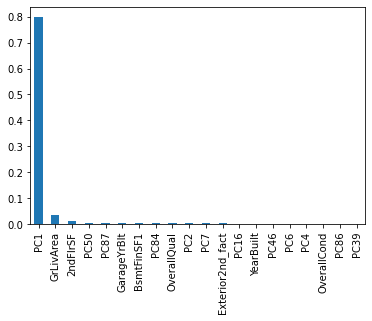

In [37]:
rf_clf = RandomForestRegressor(oob_score=True)
rf_clf.fit(houses_train_modified[feature_to_examin["kmeans_and_pca"]],houses_train["SalePrice"].values)
train_score = rf_clf.score(houses_train_modified[feature_to_examin["kmeans_and_pca"]],houses_train["SalePrice"].values)

print(f"full train data score: {train_score}")
print(f"OOB score: {rf_clf.oob_score_}")

feature_importances = pd.Series(data=rf_clf.feature_importances_, index=feature_to_examin["kmeans_and_pca"])
feature_importances.sort_values(ascending = False).head(20).plot.bar();



We can see that (unsurpisingly) by far the most important feature is the first PC created using PCA 

### Linear regression

We first want to find important features and also make sure to chose features that are somewhat independant of each other.

In [ ]:
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge

In [56]:
sorted(list(zip(pca.components_[0],cols_for_pca)),key=lambda x: -abs(x[0]))

[(0.21272987941703814, 'OverallQual'),
 (0.20544141546398728, 'Neighborhood_fact'),
 (0.20405429622913498, 'YearBuilt'),
 (0.19672002281051731, 'GarageCars'),
 (0.19660115681474966, 'BsmtQual_fact'),
 (0.19612516228217053, 'ExterQual_fact'),
 (0.18830445100534113, 'GarageArea'),
 (0.1878154972447696, 'GarageFinish_fact'),
 (0.1859765428471368, 'KitchenQual_fact'),
 (0.17988938794994264, 'GarageType_fact'),
 (0.17980241006188183, 'Foundation_fact'),
 (0.17595017268937369, 'GarageYrBlt'),
 (0.17216080141937692, 'TotalBsmtSF'),
 (0.16954789352770772, 'YearRemodAdd'),
 (0.1605613852066744, 'FullBath'),
 (0.1585480161465904, 'GrLivArea'),
 (0.15120765948593218, '1stFlrSF'),
 (0.14693096388583124, 'Exterior2nd_fact'),
 (0.1448202772118278, 'Exterior1st_fact'),
 (0.14038705185394093, 'HeatingQC_fact'),
 (0.13561871178055088, 'FireplaceQu_fact'),
 (0.13517466743984383, 'MasVnrType_fact'),
 (0.12786892636874964, 'BsmtFinType1_fact'),
 (0.12408730134375855, 'MasVnrArea'),
 (0.11751671736037027, 

Now we shall create the test prediction and save it in the required format

In [38]:
test_prediction = rf_clf.predict(houses_test_modified[feature_to_examin["kmeans_and_pca"]])

In [39]:
test_prediction_to_upload = pd.DataFrame(data = list(zip(houses_test.Id.values,test_prediction)), columns = ["Id","SalePrice"])
test_prediction_to_upload.to_csv("./houses_SalePrice_predictions.csv",sep=",",index=False)